In [1]:
#!pip install tensorflow==2.16.2
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.preprocessing import StandardScaler
import joblib


In [ ]:
print(tf.__version__)

2.16.2


In [2]:
price_df = pd.read_csv('/content/drive/MyDrive/filtered_price.csv')
news_df = pd.read_csv('/content/drive/MyDrive/price_news_return_embedding.csv')

news_df['1_day_return_positive'] = news_df['1_day_return'].apply(lambda x: 1 if x > 0 else 0)
news_df['2_day_return_positive'] = news_df['2_day_return'].apply(lambda x: 1 if x > 0 else 0)
news_df['3_day_return_positive'] = news_df['3_day_return'].apply(lambda x: 1 if x > 0 else 0)
news_df['4_day_return_positive'] = news_df['4_day_return'].apply(lambda x: 1 if x > 0 else 0)
news_df['7_day_return_positive'] = news_df['7_day_return'].apply(lambda x: 1 if x > 0 else 0)
news_df['10_day_return_positive'] = news_df['10_day_return'].apply(lambda x: 1 if x > 0 else 0)
news_df['30_day_return_positive'] = news_df['30_day_return'].apply(lambda x: 1 if x > 0 else 0)

In [3]:
news_df = news_df.sort_values(by='Date')

In [4]:
news_df.head()

,Date,Ticker,Open,High,Low,Close,Volume,Latest_News,Concatenated_News,1_day_return,...,30_day_return,Concatenated_News_Embedding,Latest_News_Embedding,1_day_return_positive,2_day_return_positive,3_day_return_positive,4_day_return_positive,7_day_return_positive,10_day_return_positive,30_day_return_positive
8794,2015-06-01,AEO,13.143777,13.191863,12.911357,13.007530,4103900.0,Genesco Misses on Q1 Earnings & Revenues; Lowe...,Genesco Misses on Q1 Earnings & Revenues; Lowe...,0.000616,...,0.115201,"[-0.029227271676063538, -0.022759385406970978,...","[-0.018616631627082825, -0.009844936430454254,...",1,1,1,1,1,1,1
8791,2015-06-01,HLT,56.807024,57.216972,56.611811,56.943672,3460136.0,Timeshares Trend: How Marriott Vacations Revam...,Timeshares Trend: How Marriott Vacations Revam...,0.000685,...,-0.027837,"[0.006758211646229029, -0.001204228145070374, ...","[-0.008595649152994156, -0.0059041185304522514...",1,1,1,1,0,0,0
8793,2015-06-01,CL,54.954373,55.292126,54.666051,55.110893,3447100.0,"Dividend, Yield, And Price: Inseparably Linked","Dividend, Yield, And Price: Inseparably Linked",-0.002548,...,0.005500,"[-0.02472446858882904, -0.021279681473970413, ...","[-0.02472446858882904, -0.021279681473970413, ...",0,0,0,0,1,0,1
8792,2015-06-01,MAR,72.173422,72.681038,71.398161,71.961151,1928200.0,Fitch ratings weighs in on lodging sector,Fitch ratings weighs in on lodging sector - Ti...,0.005865,...,-0.009190,"[0.008254693821072578, -4.126824478589697e-06,...","[0.019749974831938744, 0.00014178613491822034,...",1,1,1,1,0,0,0
8787,2015-06-02,CL,55.086177,55.250930,54.822567,54.970848,2537300.0,Can Colgate Counter Currency Woes on Inherent ...,Can Colgate Counter Currency Woes on Inherent ...,-0.002403,...,0.002690,"[0.009410146623849869, -0.0035065142437815666,...","[0.008929077535867691, -0.00028713748906739056...",0,0,0,0,0,0,1


In [5]:
# Splitting the data into train and test sets
test_idx = int(len(news_df) * 0.8)
train_df = news_df[:test_idx]
test_df = news_df[test_idx:]

X_train = np.array([np.fromstring(record.strip('[]'), sep=',') for record in train_df['Concatenated_News_Embedding']])
X_test = np.array([np.fromstring(record.strip('[]'), sep=',') for record in test_df['Concatenated_News_Embedding']])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
print(X_train.shape)
print(X_test.shape)

(7036, 1536)
(1759, 1536)


In [7]:
y_train = np.array(train_df[['1_day_return_positive', '2_day_return_positive', '3_day_return_positive', '4_day_return_positive', '7_day_return_positive', '10_day_return_positive', '30_day_return_positive']])
y_test = np.array(test_df[['1_day_return_positive', '2_day_return_positive', '3_day_return_positive', '4_day_return_positive', '7_day_return_positive', '10_day_return_positive', '30_day_return_positive']])

In [8]:
print(y_train.shape)
print(y_test.shape)

(7036, 7)
(1759, 7)


In [9]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# Feed Forward

In [ ]:
model = Sequential([
    # Input layer & first dense layer
    Dense(1024, input_shape=(1536,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.3),


    Dense(2048, kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.3),


    Dense(512, kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.3),


    Dense(256, kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Output layer
    Dense(7, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 1024)                │       1,573,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2048)                │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,870,663 (18.58 MB)

 Trainable params: 4,862,983 (18.55 MB)

 Non-trainable params: 7,680 (30.00 KB)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    baseline=0.95,
    restore_best_weights=True,
    patience=20,  # Number of epochs to wait after condition is met
    verbose=3
)

In [ ]:
history = model.fit(X_train, y_train, epochs=40, batch_size=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')

Epoch 1/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 24s 71ms/step - accuracy: 0.1275 - loss: 46.3865 - val_accuracy: 0.0620 - val_loss: 4.1896
Epoch 2/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1255 - loss: 2.6350 - val_accuracy: 0.0415 - val_loss: 0.9424
Epoch 3/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1189 - loss: 0.9522 - val_accuracy: 0.0375 - val_loss: 0.8728
Epoch 4/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1173 - loss: 0.8876 - val_accuracy: 0.0767 - val_loss: 0.8406
Epoch 5/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1206 - loss: 0.8652 - val_accuracy: 0.0984 - val_loss: 0.8674
Epoch 6/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1186 - loss: 0.8867 - val_accuracy: 0.0682 - val_loss: 0.8775
Epoch 7/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0942 - loss: 0.8607 - val_accuracy: 0.1109 - val_loss: 0.8337
Epoch 8/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1032 - loss: 0.8460 - val_accuracy:

In [ ]:
y_prob = model.predict(X_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
y_prob.shape

(1759, 7)

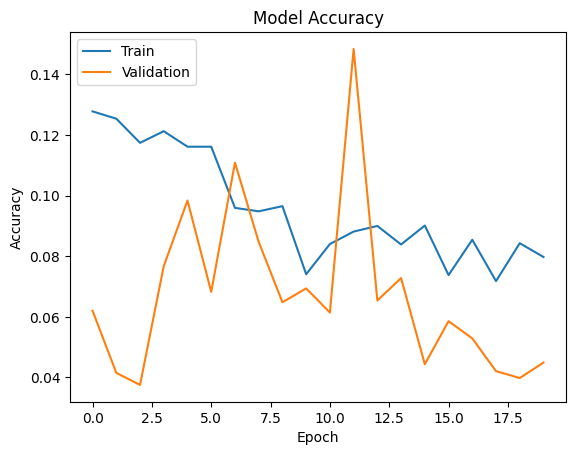

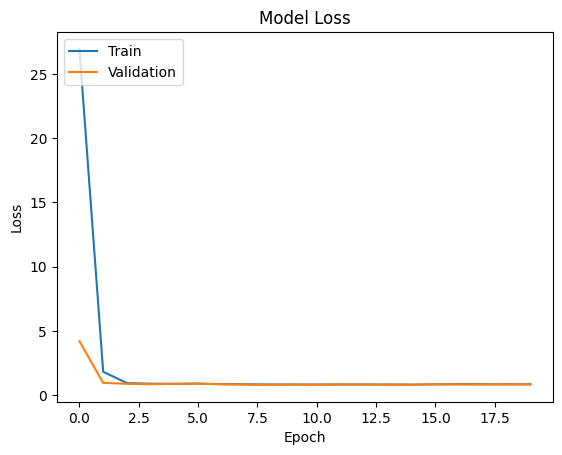

In [ ]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
y_pred_binary = np.where(y_prob > 0.40, 1, 0)

# Print classification report

print('Classification Report:')
print(classification_report(y_test, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.52      1.00      0.69       922
           1       0.54      0.96      0.69       936
           2       0.55      0.96      0.70       948
           3       0.56      0.94      0.70       954
           4       0.59      0.92      0.72      1007
           5       0.58      0.99      0.73      1020
           6       0.57      0.96      0.72       986

   micro avg       0.56      0.96      0.71      6773
   macro avg       0.56      0.96      0.71      6773
weighted avg       0.56      0.96      0.71      6773
 samples avg       0.55      0.84      0.62      6773



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.save('feedforward.keras')

# LSTM

In [ ]:
def create_sequences(X, y, window_size):
    X_seqs = []
    y_labels = []
    for i in range(len(X) - window_size):
        X_seq = X[i:i + window_size]  # Create a window of features
        y_label = y[i + window_size]  # Get the label corresponding to the end of the window
        X_seqs.append(X_seq)
        y_labels.append(y_label)
    return np.array(X_seqs), np.array(y_labels)

In [ ]:
window_size = 30
X_train, y_train = create_sequences(X_train, y_train, window_size)
X_test, y_test = create_sequences(X_test, y_test, window_size)

In [ ]:
print("X_train shape:", X_train.shape)  # Should show 80% of your samples
print("X_test shape:", X_test.shape)   # Should show the remaining 20%
print("y_train shape:", y_train.shape) # Corresponding 80% labels
print("y_test shape:", y_test.shape)   # Remaining 20% labels

X_train shape: (7006, 30, 1536)
X_test shape: (1729, 30, 1536)
y_train shape: (7006, 7)
y_test shape: (1729, 7)


In [ ]:
lstm = Sequential([
    LSTM(256, input_shape=(30, 1536), return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    BatchNormalization(),

    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    BatchNormalization(),

    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    BatchNormalization(),

    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    BatchNormalization(),

    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),

    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),

    Dense(7, activation='sigmoid')
])

# Compile the model
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
lstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 30, 256)             │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 30, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 30, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 30, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │             119 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,094,407 (7.99 MB)

 Trainable params: 2,093,223 (7.99 MB)

 Non-trainable params: 1,184 (4.62 KB)

In [ ]:
history = lstm.fit(X_train, y_train, epochs=30, batch_size=100, validation_data=(X_test, y_test))#, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = lstm.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')

Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.1540 - loss: 14.1453 - val_accuracy: 0.3008 - val_loss: 4.0803
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.1315 - loss: 3.4711 - val_accuracy: 0.0584 - val_loss: 2.0001
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.1266 - loss: 1.8503 - val_accuracy: 0.0521 - val_loss: 1.3483
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.1288 - loss: 1.2055 - val_accuracy: 0.0619 - val_loss: 1.0263
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.1366 - loss: 0.9384 - val_accuracy: 0.0619 - val_loss: 0.8957
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.1061 - loss: 0.8473 - val_accuracy: 0.0596 - val_loss: 0.8347
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.1412 - loss: 0.7869 - val_accuracy: 0.0573 - val_loss: 0.7946
Epoch 8/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.1018 - loss: 0.7985 - val_accuracy: 0.0659 -

In [ ]:
y_prob = lstm.predict(X_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


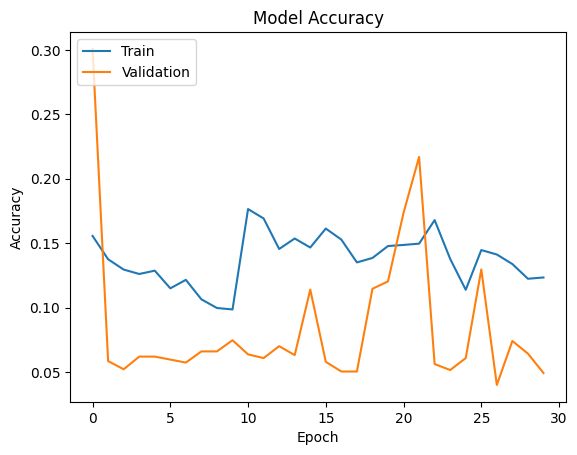

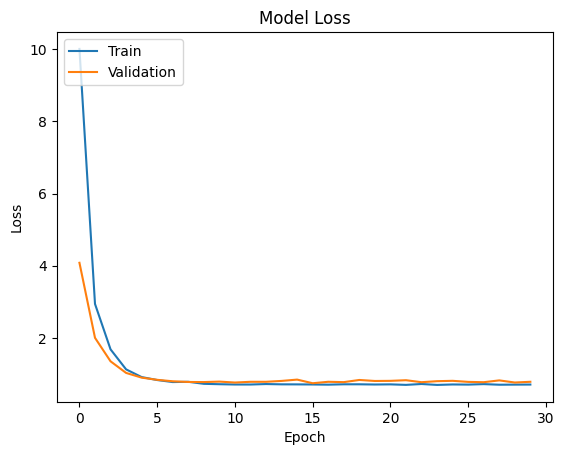

In [ ]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
y_pred_binary = np.where(y_prob > 0.40, 1, 0)

# Print classification report

print('Classification Report:')
print(classification_report(y_test, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.94      0.67       895
           1       0.52      0.85      0.64       908
           2       0.52      0.85      0.65       919
           3       0.54      0.86      0.66       926
           4       0.57      0.87      0.69       980
           5       0.57      0.97      0.72       994
           6       0.56      1.00      0.71       961

   micro avg       0.54      0.91      0.68      6583
   macro avg       0.54      0.91      0.68      6583
weighted avg       0.54      0.91      0.68      6583
 samples avg       0.55      0.80      0.60      6583



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_test.shape

(1729, 30, 1536)